# Feedforward Network with Credit Card Fraud

Credit Card Transactions Fraud Detection Example:

The notebook demonstrates how to develop a fraud detection application with the BigDL deep learning library on Apache Spark. We'll try to introduce some techniques that can be used for training a fraud detection model, but some advanced skills is not applicable since the dataset is highly simplified.

Dataset: Credit Card Fraud Detection https://www.kaggle.com/dalpozz/creditcardfraud

This dataset presents transactions that occurred in two days, where we got 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. 

Unfortunately, due to confidentiality issues, we cannot find the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Contact: yuhao.yang@intel.com


In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.models.ml_pipeline.dl_classifier import *
from utils import *

from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


init_engine()

In [2]:
learning_rate = 0.01
training_epochs = 100
batch_size = 1000
display_step = 1

# Network Parameters
n_input = 28
n_classes = 2
n_hidden_1 = 100 # 1st layer number of features
n_hidden_2 = 100 # 2nd layer number of features

LABELS = ["Normal", "Fraud"]

cols = ["V" + str(x) for x in list(range(1,28))]



In [3]:
cc_training = spark.read.csv("../data/creditcardfraud/creditcard-small.csv.gz", header=True, inferSchema="true", mode="DROPMALFORMED")

In [4]:
df = pd.read_csv("../data/creditcardfraud/creditcard.csv")

In [5]:
cc_training.select('Time', 'V1', 'V2', 'Amount', 'Class').describe().show()

+-------+-----------------+--------------------+-------------------+------------------+-------------------+
|summary|             Time|                  V1|                 V2|            Amount|              Class|
+-------+-----------------+--------------------+-------------------+------------------+-------------------+
|  count|             9061|                9061|               9061|              9061|               9061|
|   mean|93758.12713828495|-0.25424247762411734|0.17199660579747025| 89.94237611742561| 1.0542986425339367|
| stddev|47581.01643785861|  2.7091274040820754|   2.09513286985668|252.94831781126243|0.22661855121864016|
|    min|               35|   -33.0171744306281|  -39.8183101230426|               0.0|                  1|
|    max|           172741|    2.40466311881484|   22.0577289904909|          11898.09|                  2|
+-------+-----------------+--------------------+-------------------+------------------+-------------------+



In [6]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])
cc_training = cc_training.withColumn("label", cc_training["Class"])


## Dataset Balance

Let us see the dataset balance. We suspect a highly unbalanced dataset -- let us visualize. that.

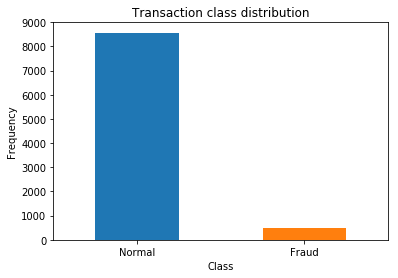

In [7]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('Class').toPandas()['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
# get the time to split the data.
splitTime = cc_training.stat.approxQuantile("Time", [0.7], 0.001)[0]

trainingData =cc_training.filter("Time < " + str(splitTime))
validData = cc_training.filter("Time >= " + str(splitTime))

## Feature analysis:
Normally it would improve the model if we could derive more features from the raw transaction records. E.g.
days to last transaction,
distance with last transaction,
amount percentage over the last 1 month / 3months
...

Yet with the public dataset, we can hardly derive any extention features from the PCA result. So here we only introduce several general practices:

Usually there's a lot of categorical data in the raw dataset, E.g. post code, card type, merchandise id, seller id, etc. 

1). For categorical feature with limited candidate values, like card type, channel id, just use OneHotEncoder. 

2). For categorical feature with many candidate values, like merchandise id, post code or even phone number, suggest to use Weight of Evidence. 

3). You can also use FeatureHasher from Spark MLlib which will be release with Spark 2.3.
For this dataset, essentially it's a classification problem with highly unbalanced data set.

## Approach

We will build a feature transform pipeline with Apache Spark and some of our transformers.
We will run some inital statistical analysis and split the dataset for training and validation.
We will build the model with BigDL.
We will compare different strategy to handle the unbalance.
Details of each step is as follows:

### step 1. Build an inital pipeline for feature transform.
For each training records, we intend to aggregate all the features into one Spark Vector, which will then be sent to BigDL model for the training. First we'd like to introduce one handy transformer that we developed to help user build custom Transformers for Spark ML Pipeline.
```
class FuncTransformer (
  override val uid: String,
  val func: UserDefinedFunction
) extends Transformer with HasInputCol with HasOutputCol with DefaultParamsWritable {
```
FuncTransformer takes an udf as the constructor parameter and use the udf to perform the actual transform. The transformer can be saved/loaded as other transformer and can be integrated into a pipeline normally. It can be used widely in many use cases like conditional conversion(if...else...), , type conversion, to/from Array, to/from Vector and many string ops. Some examples:
```
val labelConverter = new FuncTransformer(udf { i: Double => if (i >= 1) 1 else 0 })
```

```
val shifter = new FuncTransformer(udf { i: Double => i + 1 })
```

```
val toVector = new FuncTransformer(udf { i: Double => Vectors.dense(i) })
```

We will use VectorAssembler to compose the all the Vx columns and append the Amount column. Then use StandardScaler to normlize the training records. Since in BigDL, the criterion generally only accepts 1, 2, 3... as the Label, so we will replace all the 0 with 2 in the training data.

In [ ]:
assembler =  VectorAssembler(inputCols=cols, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(trainingData)
data_training = pipelineTraining.transform(trainingData)
pipelineTest = pipeline.fit(validData)
data_test = pipelineTraining.transform(validData)

### step 2. split the dataset into training and validation dataset.

Unlike some other training dataset, where the data does not have a time of occurance. For this case, we can know the sequence of the transactions from the Time column. Thus randomly splitting the data into training and validation does not make much sense, since in real world applications, we can only use the history transactions for training and use the latest transactions for validation. Thus we'll split the dataset according the time of occurance.

### step 3. Build the model with BigDL
From the research community and industry feedback, a simple neural network turns out be the perfect candidate for the fraud detection training. We will quickly build a multiple layer Perceptron with linear layers.
```
    val bigDLModel = Sequential()
      .add(Linear(29, 10))
      .add(Linear(10, 2))
      .add(LogSoftMax())
    val criterion = ClassNLLCriterion()
```

BigDL provides DLEstimator and DLClassifier for users with Apache Spark MLlib experience, which provides high level API for training a BigDL Model with the Apache Spark Estimator/Transfomer pattern, thus users can conveniently fit BigDL into a ML pipeline. The fitted model DLModel and DLClassiferModel contains the trained BigDL model and extends the Spark ML Model class. Alternatively users may also construct a DLModel with a pre-trained BigDL model to use it in Spark ML Pipeline for prediction.

DLClassifier is a specialized DLEstimator that simplifies the data format for classification tasks. It only supports label column of DoubleType, and the fitted DLClassifierModel will have the prediction column of DoubleType.

For this case we'll just use DLClassifier for the training. Note that users can set differet optimization mothod, batch size and epoch number.


In [ ]:

bigDLModel = Sequential().add(Linear(n_input, n_hidden_1)).add(Linear(n_hidden_1, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(batch_size)
model = dlClassifier.fit(data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier


In [ ]:
from pyspark.sql import DataFrame, SQLContext
predictionDF = DataFrame(model.transform(cc_data_test), SQLContext(sc))
predictionDF


Now we have finished the training of our first model (which is certainly not the best, keep reading!).

We'll need to think about how do evaluate the trained model:

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. Since even if the model predicts all the records as normal transactions, it will still get an accuracy above 99%.

In [ ]:
predictionDF.cache() 
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + auPRC)
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + recall)

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + precision)  
predictionDF.unpersist()

In [ ]:
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

To this point, we have finished the training and evaluation with a simple BigDL model. We can see that even though the recall and precision are high, the area under precision-recall curve is not optimistic. That's because we haven't really apply any technique to handle the imbalanced training data.

Next we'll try to optimize the training process.

### step 4. handle the data imbalance
There are several ways to approach this classification problem taking into consideration this unbalance.

Collect more data? Nice strategy but not applicable in this case.

Resampling the dataset Essentially this is a method that will process the data to have an approximate 50-50 ratio. One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when there're little data) Another is UNDER-sampling, which deletes instances from the over-represented class (better when there are lots of data)
Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

We'll start with Resampling.

Since there're 492 frauds out of 284,807 transactions, to build a reasonable training dataset, we'll use UNDER-sampling for normal transactions and use OVER-sampling for fraud transactions. By using the sampling rate as fraud -> 10, normal -> 0.05, we can get a training dataset of (5K fraud + 14K normal) transactions. We can use the training data to fit a model.

Yet we'll soon find that since there're only 5% of all the normal transactions are included in the training data, the model can only cover 5% of all the normal transactions, which is obviousely not optimistic. So how can we get a better converage for the normal transactions without breaking the ideal ratio in the training dataset?

An immediate improvement would be to train multiple models. For each model, we will run the resampling from the original dataset and get a new training data set. After training, we can select best voting strategy for all the models to make the prediction.

We'll use Ensembling of neural networks. That's where a Bagging classifier becomes handy. Bagging is an Estimator we developed for ensembling of multiple other Estimator.

```
package org.apache.spark.ml.ensemble

class Bagging[M <: Model[M]](override val uid: String)
  extends Estimator[BaggingModel[M]]
  with BaggingParams[M] {
For usage, user need to set the specific Estimator to use and the number of models to be trained:
    val estimator = new Bagging()
      .setPredictor(dlClassifier)
      .setLabelCol("Class")
      .setIsClassifier(true)
      .setNumModels(10)
```

Internally, Bagging will train $(numModels) models. Each model is trained with the resampled data from the original dataset.

In [ ]:
frpm pyspark.ml.ensemble import Bagging
estimator = Bagging().setPredictor(dlClassifier).setLabelCol("Class").setIsClassifier(true).setNumModels(20)

val baggingModel = estimator.fit(cc_training)